In [124]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('seaborn') 

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Preparation

In [41]:
df = pd.read_csv('AER_credit_card_data.csv')

In [42]:
df.head(5)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


Create a mapping for `card` from yes/no to 1/0

In [43]:
df['card'] = (df.card == 'yes').astype(int)

In [44]:
df.card.sum()/len(df)

0.775587566338135

Split the dataset in train/val/test with 60%/20%/20% distribution

In [45]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

# Q1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

In [46]:
from sklearn.metrics import roc_auc_score

In [64]:
numerical = df_train.dtypes[df_train.dtypes != 'object'].index.tolist()
categorical = df_train.dtypes[df_train.dtypes == 'object'].index.tolist()

In [48]:
df_train[numerical[0]].values.shape,y_train.shape

((791,), (791,))

In [59]:
aucs = []
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    aucs.append(auc)

df_auc = pd.Series(aucs,index=numerical)
options = ['reports','dependents','active','share']
df_auc.loc[options].sort_values(ascending=False)


share         0.989184
reports       0.716663
active        0.604317
dependents    0.532776
dtype: float64

# Training the model

We will only use the following columns as features

In [60]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [71]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[columns].to_dict(orient='records')
val_dicts = df_val[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

y_preds = model.predict_proba(X_val)[:,1]

auc = round(roc_auc_score(y_true=y_val,y_score=y_preds),3)
print(f"Q2: The AUC for the val dataset is {auc}")

Q2: The AUC for the val dataset is 0.995


# Q3

Now let's compute precision and recall for our model.

Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?


In [98]:
def scores_dataframe(y_true,y_pred):

    thresholds = np.arange(0.0,1.01,0.01)

    actual_positive = (y_true == 1)
    actual_negative = (y_true == 0)

    scores = []
    for threshold in thresholds:

        pred_positive = (y_pred >= threshold)
        pred_negative = (y_pred < threshold)

        tp = (actual_positive & pred_positive).sum()
        tn = (actual_negative & pred_negative).sum()

        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()
        p = tp/(tp+fp)
        r = tp/(tp+fn)

        scores.append((threshold,tp,fp,fn,tn,p,r))

    df_scores = pd.DataFrame(scores,columns=['threshold','tp','fp','fn','tn','p','r'])
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

<AxesSubplot:xlabel='threshold'>

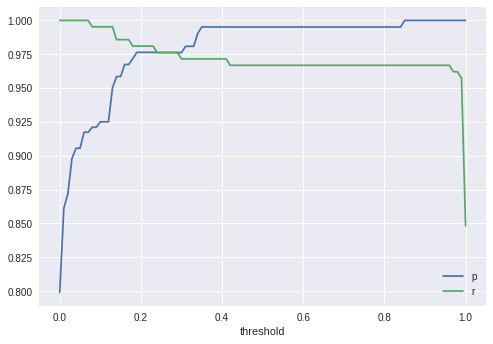

In [99]:
df_scores = scores_dataframe(y_true=y_val,y_pred=y_preds)

df_scores.plot(x='threshold',y=['p','r'])

In [100]:
df_scores[(df_scores['r']==df_scores['p'])].threshold.round(1)

24    0.2
25    0.2
26    0.3
27    0.3
28    0.3
29    0.3
Name: threshold, dtype: float64

# Q4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing :

$$F_1 = 2*\frac{P*R}{P+R} $$

Where  is precision and  is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

Text(0, 0.5, 'TPR')

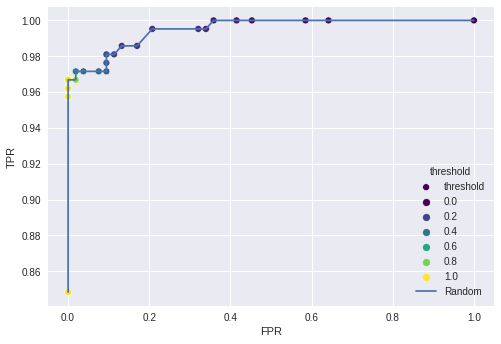

In [123]:
fig,ax=plt.subplots()

sns.scatterplot(x='fpr',y='tpr',hue='threshold',palette='viridis',data=df_scores,label='threshold',ax=ax)
df_scores.plot(x='fpr',y='tpr',label='Random',ax=ax)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

<Figure size 576x396 with 0 Axes>

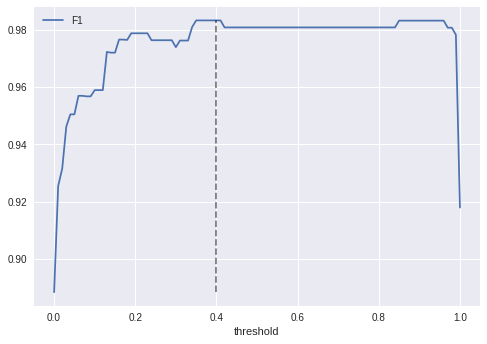

In [107]:
df_scores['F1'] = 2* (df_scores['p']*df_scores['r'])/(df_scores['p']+df_scores['r'])
tr = df_scores.loc[(df_scores['F1'] == df_scores['F1'].max()),'threshold'].max().round(1)
fig = plt.figure()
df_scores.plot(x='threshold',y='F1')
plt.vlines(x=tr,ymin=df_scores['F1'].min(),ymax=df_scores['F1'].max(),color='k',ls='--',alpha=0.5)

# Q5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24


In [110]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [115]:
def train(df,y_train,C=1.0):
    dicts = df[columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train,y_train)

    return dv,model 

def predict(df,dv,model):
    
    dicts = df[columns].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred 

In [116]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx,val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv,model = train(df_train,y_train)
    y_pred = predict(df_val,dv,model)

    auc = roc_auc_score(y_val,y_pred)

    scores.append(auc)

print('AUC %.3f +- %.3f' % (np.mean(scores),np.std(scores)))

5it [00:00, 65.58it/s]

AUC 0.996 +- 0.003


# Q6 

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [117]:
n_splits = 5

C_scores = {}
for C in tqdm([0.01, 0.1, 1, 10]):
    scores = []
    kfold = KFold(n_splits=n_splits,shuffle=True,random_state=1)
    for train_idx,val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv,model = train(df_train,y_train,C=C)
        y_pred = predict(df_val,dv,model)

        auc = roc_auc_score(y_val,y_pred)

        scores.append(auc)

    mean = np.mean(scores).round(3)
    std = np.std(scores).round(3)
    print('C=%s :AUC %.3f +- %.3f' % (C,np.mean(scores),np.std(scores)))

    C_scores.update({C:{'mean':mean,'std':std}})

100%|██████████| 4/4 [00:00<00:00, 14.81it/s]

C=0.01 :AUC 0.992 +- 0.006
C=0.1 :AUC 0.995 +- 0.004
C=1 :AUC 0.996 +- 0.003
C=10 :AUC 0.996 +- 0.003


100%|██████████| 4/4 [00:00<00:00, 14.75it/s]


In [118]:
C_scores

{0.01: {'mean': 0.992, 'std': 0.006},
 0.1: {'mean': 0.995, 'std': 0.004},
 1: {'mean': 0.996, 'std': 0.003},
 10: {'mean': 0.996, 'std': 0.003}}